In [1]:
#imports

import requests
import csv 
from flask import Flask, render_template, url_for
import os
import json
import pandas as pd
import uuid
import sys
import stat
import json
import warnings
import base64
import time
import random


#plotting
from matplotlib import pyplot
import seaborn as sns

warnings.filterwarnings("ignore")


In [2]:
path = "C:\\Users\\oskar\\OneDrive - Danmarks Tekniske Universitet\\Kandidat Speciale\\Programmering\\JSON_files\\"

json_merged=[]

#loading example file from LCAbyg and mergning them into one json-list.
for root, dirs, files in os.walk(path, topdown=False):
    for name in files:
        file = os.path.join(root, name)
        
        f = open(file)
        f_load = json.load(f)
        json_merged = json_merged+f_load
        
out_file = open("C:\\Users\\oskar\\OneDrive - Danmarks Tekniske Universitet\\Kandidat Speciale\\Programmering\\LCAbyg_API\\api_in\\example_project.json", "w")
  
json.dump(json_merged, out_file, indent = 2)
  
out_file.close()

In [3]:
with open("C:\\Users\\oskar\\OneDrive - Danmarks Tekniske Universitet\\Kandidat Speciale\\Programmering\\RevitQuantities\\Building.txt") as f:
    contents = f.read()

gfa = float(contents.split(",")[1])

In [4]:
gfa

278.1

In [5]:
def send_job(input_path, output_path, username, password):
    print('Preparing data:')
    with open(input_path, 'r', encoding='utf-8') as f:
        input_json = f.read()
    target = 'lcabyg5_calc'
    user_group = 'Test'
    job_data = {
        'priority': 0,
        'job_target': target,
        'job_target_min_ver': '',
        'job_target_max_ver': '',
        'job_arguments': '',
        'input_blob': base64.standard_b64encode(input_json.encode('utf-8')).decode('utf-8'),
    }
    print()

    print('Finding a server:')
    job_queue_url = get_a_job_server(target, user_group)
    print(f'job_queue_url = {job_queue_url}')
    print()

    print('Sending ping:')
    res_ping = ping(job_queue_url)
    print(f'res_ping = {res_ping}')
    print()

    print('Logging in:')
    token = login(job_queue_url, username, password)
    print(f'token = {token}')
    print()

    print('Submitting a new job:')
    job_id = new_job(job_queue_url, token, job_data)
    print(f'job_id = {job_id}')
    print()

    print('Waiting for the job to finish:')
    done = False
    while not done:
        status = job_status(job_queue_url, token, job_id)
        print(f'status = {status["status"]}')
        done = (status['status'] == 'Ready') or (status['status'] == 'Failed')
        time.sleep(1)
    print()

    print('Download the results:')
    job_output_raw = get_job_output(job_queue_url, token, job_id)
    job_output = base64.b64decode(job_output_raw).decode('utf-8')
    print()

    print('Saving the results to disk:')
    data = json.loads(job_output)
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=2, ensure_ascii=False)
    print()

    print('Done')

In [7]:
DIRECTORY_URL = 'https://swa-dir-a.buildsrv.dk'


def get_a_job_server(target, user_type):
    res = requests.get(DIRECTORY_URL).json()

    assert res['version'] == 1

    alternatives = list()
    for srv in res['job_queues']:
        if target in srv['supported_targets'] and user_type in srv['allowed_users']:
            alternatives.append(srv)

    assert len(alternatives) > 0
    return random.choice(alternatives)['url']


def ping(job_queue_url):
    res = requests.get(f'{job_queue_url}/v1/ping').text
    assert res == 'pong'
    return res


def login(job_queue_url, username, password):
    data = {
        'username': username,
        'password': password,
    }
    json_data = json.dumps(data)
    res = requests.post(f'{job_queue_url}/v1/login', json_data)
    data = json.loads(res.text)
    return data


def new_job(job_queue_url, token, job_data):
    auth_headers = {
        'Session': token,
    }
    res = requests.post(f'{job_queue_url}/v1/jobs', json=job_data, headers=auth_headers)
    data = json.loads(res.text)
    return data


def job_status(job_queue_url, token, job_id):
    auth_headers = {
        'Session': token,
    }
    res = requests.get(f'{job_queue_url}/v1/jobs/{job_id}', headers=auth_headers)
    return res.json()


def job_delete(job_queue_url, token, job_id):
    auth_headers = {
        'Session': token,
    }
    res = requests.get(f'{job_queue_url}/v1/jobs/{job_id}', headers=auth_headers)
    return res.json()


def get_job_output(job_queue_url, token, job_id):
    auth_headers = {
        'Session': token,
    }
    res = requests.get(f'{job_queue_url}/v1/jobs/{job_id}/output', headers=auth_headers)
    return res.json()


def send_job(input_path, output_path, username, password):
    print('Preparing data:')
    with open(input_path, 'r', encoding='utf-8') as f:
        input_json = f.read()
    target = 'lcabyg5_calc'
    user_group = 'Test'
    job_data = {
        'priority': 0,
        'job_target': target,
        'job_target_min_ver': '',
        'job_target_max_ver': '',
        'job_arguments': '',
        'input_blob': base64.standard_b64encode(input_json.encode('utf-8')).decode('utf-8'),
    }
    print()

    print('Finding a server:')
    job_queue_url = get_a_job_server(target, user_group)
    print(f'job_queue_url = {job_queue_url}')
    print()

    print('Sending ping:')
    res_ping = ping(job_queue_url)
    print(f'res_ping = {res_ping}')
    print()

    print('Logging in:')
    token = login(job_queue_url, username, password)
    print(f'token = {token}')
    print()

    print('Submitting a new job:')
    job_id = new_job(job_queue_url, token, job_data)
    print(f'job_id = {job_id}')
    print()

    print('Waiting for the job to finish:')
    done = False
    while not done:
        status = job_status(job_queue_url, token, job_id)
        print(f'status = {status["status"]}')
        done = (status['status'] == 'Ready') or (status['status'] == 'Failed')
        time.sleep(1)
    print()

    print('Download the results:')
    job_output_raw = get_job_output(job_queue_url, token, job_id)
    job_output = base64.b64decode(job_output_raw).decode('utf-8')
    print()

    print('Saving the results to disk:')
    data = json.loads(job_output)
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=2, ensure_ascii=False)
    print()

    print('Done')


def main():
    username = "oskargram1996@gmail.com"
    password = "da3f75d0-a94f-4700-ba7c-39882cb0f0bc"

    input_json = "C:\\Users\\oskar\\OneDrive - Danmarks Tekniske Universitet\\Kandidat Speciale\\Programmering\\LCAbyg_API\\api_in\\example_project.json"
    output_json = "C:\\Users\\oskar\\OneDrive - Danmarks Tekniske Universitet\\Kandidat Speciale\\Programmering\\LCAbyg_API\\api_out\\result_json.json"

    send_job(input_json, output_json, username, password)

main()

Preparing data:

Finding a server:


ConnectionError: HTTPSConnectionPool(host='swa-dir-a.buildsrv.dk', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001713BFDB910>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [ ]:
file = "C:\\Users\\oskar\\OneDrive - Danmarks Tekniske Universitet\\Kandidat Speciale\\Programmering\\LCAbyg_API\\api_out\\result_json.json"
f = open(file)
f_load = json.load(f)

building_id = '6d766aa5-50aa-4005-ab35-29f2fb82ddad'

results = f_load['results'][building_id]['SumNew']['9999']

In [14]:
results

{'GWP_IOBC': 0.0,
 'ADPE': 0.5997015720909085,
 'PER': 5946946.9909608085,
 'AP': 20849.224683321776,
 'ODP': 3.232893253330261e-08,
 'GWP': 3918009.838445652,
 'ADPF': 32955840.17307249,
 'PENR': 34694034.02446686,
 'SER': 4813.263662929469,
 'GWP_BC': 0.0,
 'SENR': 45344.84029281698,
 'EP': 1893.7120390408822,
 'POCP': 967.3542739448202}

<AxesSubplot: xlabel='Impact Categories', ylabel='Value total'>

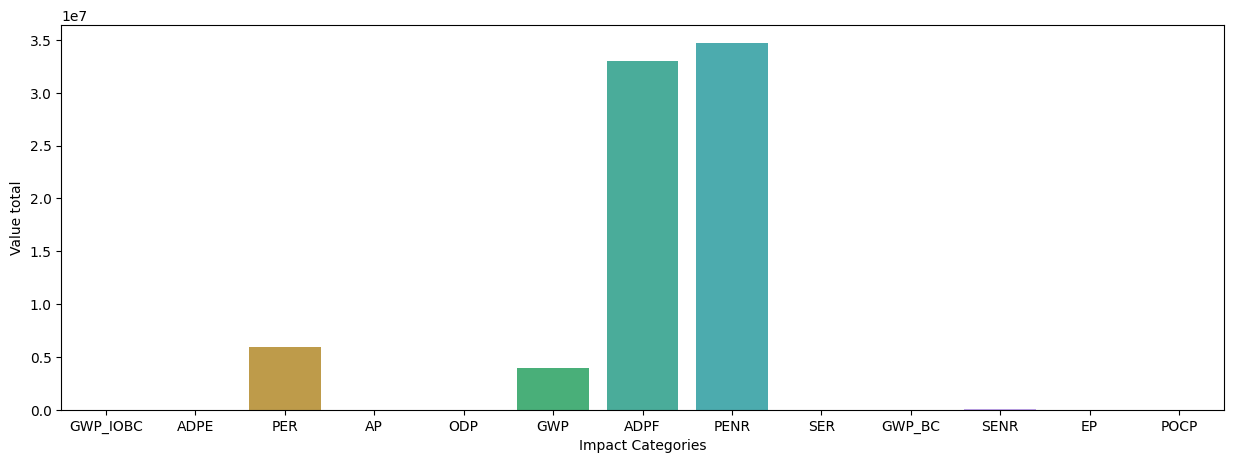

In [15]:
df = pd.DataFrame((results).items(), columns=['Impact Categories', 'Value total'])

a4_dims = (15, 5)

fig, ax = pyplot.subplots(figsize=a4_dims)

sns.barplot(ax = ax, data=df, x="Impact Categories", y="Value total")

In [41]:
# df['Value / m2 / year'] = df['Value total']/gfa
df['Value / m2 / year'] = round(df['Value total']/(gfa*50),2)

In [42]:
df['Walls'] = df["Value / m2 / year"]/0.3
df['Floor'] = df["Value / m2 / year"]/0.2
df['Roof'] = df["Value / m2 / year"]/0.25
df['Ceiling'] = df["Value / m2 / year"]/0.25


In [43]:
df[['Impact Categories','Walls','Floor','Roof','Ceiling']]


,Impact Categories,Walls,Floor,Roof,Ceiling
0,GWP_IOBC,0.000000,0.00,0.00,0.00
1,ADPE,0.000000,0.00,0.00,0.00
2,PER,75.466667,113.20,90.56,90.56
3,AP,0.266667,0.40,0.32,0.32
4,ODP,0.000000,0.00,0.00,0.00
5,GWP,49.733333,74.60,59.68,59.68
6,ADPF,418.266667,627.40,501.92,501.92
7,PENR,440.333333,660.50,528.40,528.40
8,SER,0.066667,0.10,0.08,0.08
9,GWP_BC,0.000000,0.00,0.00,0.00


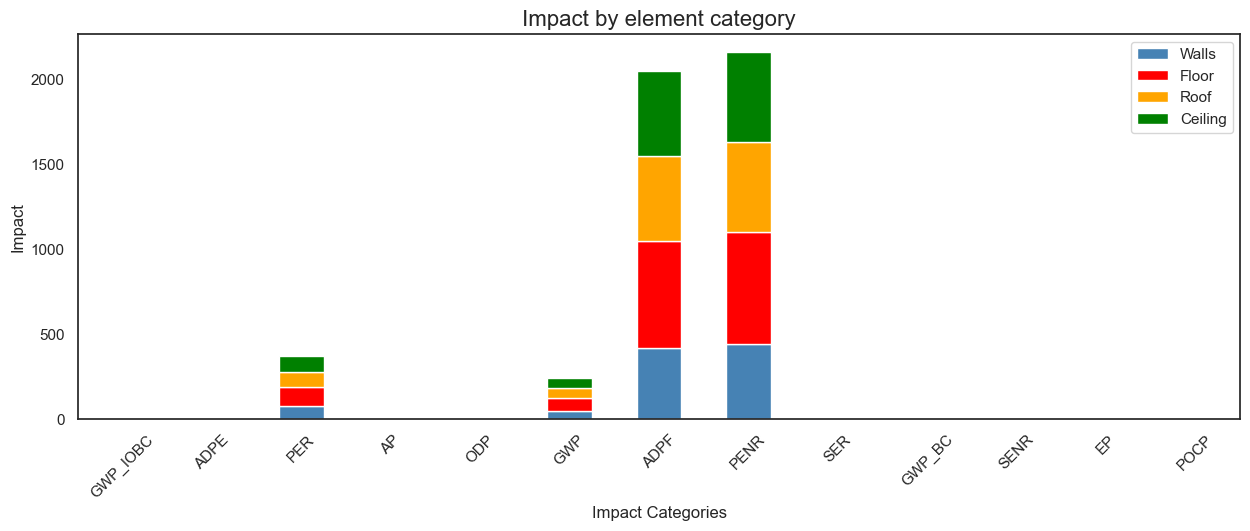

: 

In [52]:
#set seaborn plotting aesthetics

import matplotlib.pyplot as plt
df['Value / m2 / year'] = round(df['Value total']/(gfa*50),2)

df_new = df[['Impact Categories','Walls','Floor','Roof','Ceiling']]

a4_dims = (15, 5)
sns.set(style='white')

#create stacked bar chart
df_new.set_index('Impact Categories').plot(kind='bar', stacked=True, color=['steelblue', 'red', 'orange', 'green'],figsize= (15, 5))

#add overall title
plt.title('Impact by element category', fontsize=16)

#add axis titles
plt.xlabel('Impact Categories')
plt.ylabel('Impact')

#rotate x-axis labels
plt.xticks(rotation=45)

plt.show()


<AxesSubplot: xlabel='Impact Categories', ylabel='Value / m2 / year'>

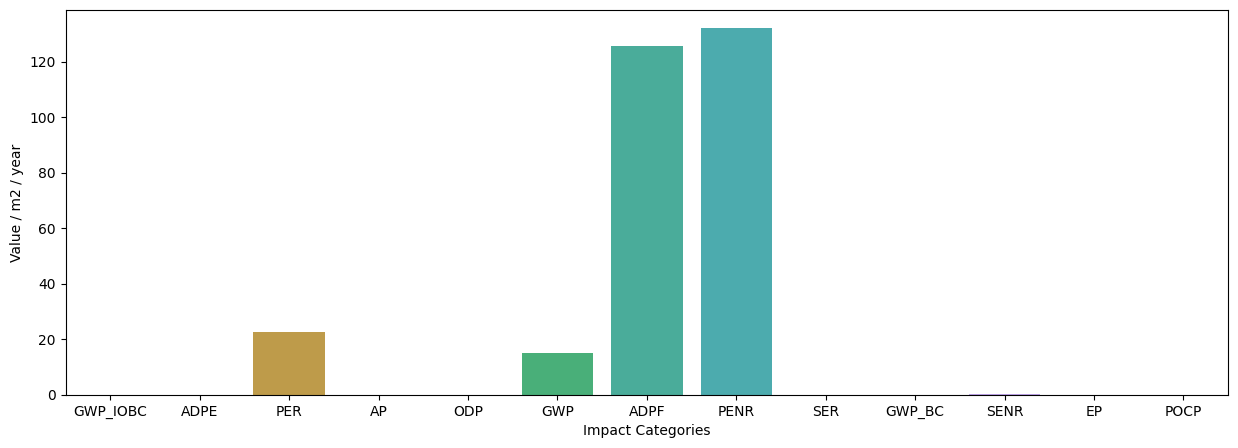

In [26]:
df['Value / m2 / year'] = round(df['Value total']/(gfa*50),2)

a4_dims = (15, 5)

fig, ax = pyplot.subplots(figsize=a4_dims)

sns.barplot(ax = ax, data=df, x="Impact Categories", y="Value / m2 / year")

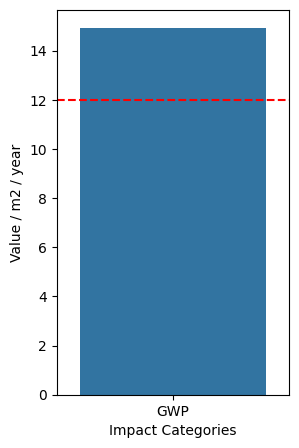

In [27]:
import matplotlib.pyplot as plt
a4_dims = (3, 5)

fig, ax = pyplot.subplots(figsize=a4_dims)

graph =sns.barplot(ax = ax, data=df[df["Impact Categories"] == "GWP"], x="Impact Categories", y="Value / m2 / year")

graph.axhline(12, color = "red", linestyle = "--")
#The plot is shown
plt.show()

In [28]:
gfa

5252.8

In [29]:
df[df["Impact Categories"] == "GWP"]

,Impact Categories,Value total,Value / m2 / year
5,GWP,3.918010e+06,14.92
